In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# #2: Stress-Testing OOS Results

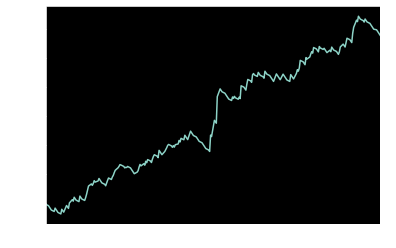

In [2]:
bt_data = pd.read_csv('Short Strangle(Stock Mock Backtest Index Strategies) (1).csv')

bt_data = bt_data['Profit'].dropna()
bt_data = bt_data[bt_data != 'Profit']
bt_data = bt_data.apply(float)
bt_data.cumsum().plot()

In [3]:
def get_stats(pnl):
    r = np.sum(pnl)
    mdd = (np.cumsum(pnl) - np.maximum.accumulate(np.cumsum(pnl))).min()
    rmdd = -r/mdd
    return r, mdd, rmdd

def sample_from_pnl(pnl):
    return np.random.choice(pnl, len(pnl))

def sample_and_stats(pnl):
    pnl = sample_from_pnl(pnl)
    pnls.append(pnl)
    r, mdd, rmdd = get_stats(pnl)
    rs.append(r)
    mdds.append(mdd)
    rmdds.append(rmdd)
    return r, mdd, rmdd

In [4]:
get_stats(bt_data)

(57634.0, -7000.0, 8.233428571428572)

In [5]:
pnl = bt_data.values

In [10]:
pnls = []
rs = []
mdds = []
rmdds = []

num_of_iters = 100

for _ in range(num_of_iters):
    sample_and_stats(pnl)

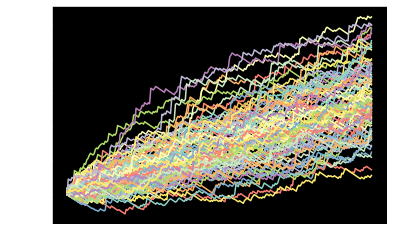

In [11]:
list(map(lambda x: plt.plot(np.cumsum(x)), pnls))
plt.show()

***
### Parallelization

In [12]:
import multiprocessing as mp
import time

In [30]:
num_of_iters = 500

In [31]:
# Sequential 

pnls = []
rs = []
mdds = []
rmdds = []

start_time = time.time()
for _ in range(num_of_iters):
    sample_and_stats(pnl)
end_time = time.time()

print(f"Sequential Time for {num_of_iters} iterations is {round(end_time - start_time, 3)}")

Sequential Time for 500 iterations is 0.016


In [32]:
# Parallel
pnls = []
rs = []
mdds = []
rmdds = []

start_time = time.time()
pool = mp.Pool(mp.cpu_count())
results = pool.map(sample_and_stats, [pnl for _ in range(num_of_iters)])
pool.close()
end_time = time.time()

print(f"Parallel Time for {num_of_iters} iterations is {round(end_time - start_time, 3)}")

Parallel Time for 500 iterations is 0.125


In [33]:
rs = pd.DataFrame(results).transpose().values[0]
mdds = pd.DataFrame(results).transpose().values[1]
rmdds = pd.DataFrame(results).transpose().values[2]

In [34]:
np.max(rmdds)

24.358640636297903

In [35]:
np.min(rmdds)

1.139720454782518

In [36]:
mdds.sort()

<BarContainer object of 500 artists>

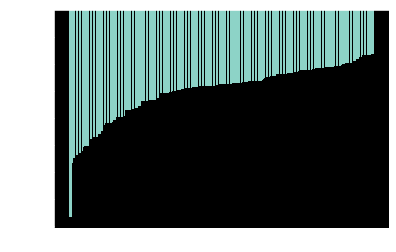

In [37]:
plt.bar(range(len(mdds)), mdds)

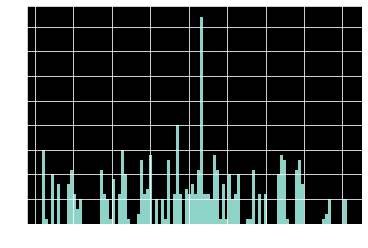

In [38]:
pd.Series(rs).hist(bins=100)

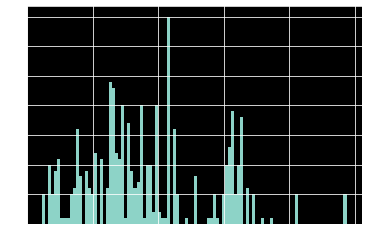

In [39]:
pd.Series(rmdds).hist(bins=100)

In [40]:
np.mean(mdds) - np.std(mdds)*2

-12617.825602255409

In [41]:
np.std(mdds)

2574.860801127704

In [42]:
np.mean(rmdds)

9.163138540716536

In [43]:
np.mean(rmdds) - np.std(rmdds)*1

4.421753992072676

In [44]:
np.mean(rmdds) - np.std(rmdds)*2

-0.3196305565711839

In [45]:
pd.Series(rmdds).describe()

count    500.000000
mean       9.163139
std        4.746133
min        1.139720
25%        6.110408
50%        8.330140
75%       11.349477
max       24.358641
dtype: float64

In [46]:
np.min(mdds)

-19174.0

In [47]:
pd.Series(mdds).describe()

count      500.000000
mean     -7468.104000
std       2577.439531
min     -19174.000000
25%      -8408.000000
50%      -6861.000000
75%      -5713.000000
max      -4080.000000
dtype: float64

***
# #3: Optimal Asset Allocation

In [48]:
import glob

In [49]:
stocks = glob.glob('/home/blackrose/active/appledore/data-processed/stocks/pickle/*')

In [50]:
tickers = []
price_data = pd.DataFrame()

In [51]:
for filepath in stocks[:20]:
    tickers.append(filepath.split('/')[-1])
    x = pd.read_pickle(filepath)
    x = x.resample('D')['close'].last().dropna()
    price_data = pd.concat([price_data, x], axis=1)
price_data.columns = tickers

In [52]:
price_data = price_data.dropna()

In [53]:
log_returns = np.log(price_data/price_data.shift())

In [54]:
log_returns.mean()

HEROMOTOCO   -0.000237
TITAN         0.001091
MOTHERSUMI   -0.000407
PNBHOUSING   -0.001558
INDIANB      -0.001274
APOLLOTYRE   -0.000567
GRASIM       -0.000454
MANAPPURAM    0.000509
SUNPHARMA    -0.000338
GODREJIND    -0.000053
ASHOKLEY     -0.000603
IBULHSGFIN   -0.001378
ASIANPAINT    0.000538
HINDZINC     -0.000353
MUTHOOTFIN    0.001230
FORTIS       -0.000352
NTPC         -0.000386
INDIACEM     -0.000226
MCX          -0.000049
INDIGO        0.000125
dtype: float64

In [55]:
equal_weight = np.zeros(len(tickers)) + 1/len(tickers)

In [57]:
weights = equal_weight

ret = weights@log_returns.mean().values

vol = (weights@log_returns.cov()@weights.T)**0.5

sharpe = ret/vol

In [58]:
sharpe

-0.016404475526016184

In [59]:
x = np.random.random(len(equal_weight))

In [60]:
weights = x/sum(x)

In [61]:
list_of_weights = []
list_of_sharpes = []

for _ in range(10000):
    x = np.random.random(len(equal_weight))
    weights = x/sum(x)
    ret = weights@log_returns.mean().values
    vol = (weights@log_returns.cov()@weights.T)**0.5
    sharpe = ret/vol
    list_of_weights.append(weights)
    list_of_sharpes.append(sharpe)

In [62]:
np.max(list_of_sharpes)

0.007525778774359622

In [63]:
list_of_weights[(list_of_sharpes == np.max(list_of_sharpes)).nonzero()[0][0]]

array([0.09475533, 0.11841082, 0.0142155 , 0.02241272, 0.04848242,
       0.03080618, 0.12131233, 0.06038419, 0.02298139, 0.03569473,
       0.03464278, 0.00429659, 0.05338864, 0.00505093, 0.13550967,
       0.02905301, 0.03393889, 0.00607869, 0.0073628 , 0.12122239])

***
# #4: Exotic Option Pricing
